In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D

In [2]:
url_train = 'https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/master/data/train.csv'
url_val = 'https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/master/data/val.csv'
url_test = 'https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/master/data/test.csv'

df_train = pd.read_csv(url_train, index_col=0)
df_val = pd.read_csv(url_val, index_col=0)
df_test = pd.read_csv(url_test, index_col=0)

In [3]:
class DataWindow:
    def __init__(self, input_width, label_width, shift, df_train, df_val, df_test, label_columns=None):
        # window size
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.total_window_size = input_width + shift
        
        # データ
        self.df_train = df_train
        self.df_val = df_val
        self.df_test = df_test
        
        # ラベル
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(self.df_train.columns)}
        
        # スライス
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        # ラベル開始位置
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels
    
    def plot(self, plot_col: str, model=None, max_subplots=3):
        inputs, labels = self.sample_batch
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        n_max = min(max_subplots, len(inputs))
        
        for n in range(n_max):
            plt.subplot(n_max, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index], label='Inputs', marker='.', zorder=-10)
            
            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index
            
            if label_col_index is None:
                continue
            
            plt.scatter(self.label_indices, labels[n, :, label_col_index], edgecolors='k', label='Labels', c='tab:green', s=64)
            
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index], marker='X', edgecolors='k', label='Predictions', c='tab:red', s=64)
            
            if n == 0:
                plt.legend()
        plt.xlabel('Time (h)')
    
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,
        )
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.df_train)
    
    @property
    def val(self):
        return self.make_dataset(self.df_val)
    
    @property
    def test(self):
        return self.make_dataset(self.df_test)
    
    @property
    def sample_batch(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [4]:
# for training
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min'
    )
    model.compile(
        loss=MeanSquaredError(),
        optimizer=Adam(),
        metrics=[MeanAbsoluteError()]
    )
    history = model.fit(
        window.train,
        epochs=max_epochs,
        validation_data=window.val,
        callbacks=[early_stopping]
    )
    return history

In [6]:
# models
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        elif isinstance(self.label_index, list):
            tensors = []
            for index in self.label_index:
                res = inputs[:, :, index]
                res = res[:, :, tf.newaxis]
                tensors.append(res)
            return tf.concat(tensors, axis=-1)
        else:
            res = inputs[:, :, self.label_index]
            return res[:, :, tf.newaxis]

class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
    
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])
    
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
    
    def call(self, inputs):
        return inputs[:, :, self.label_index:]

# 線形モデル
linear = Sequential([Dense(units=1)])
ms_linear = Sequential([Dense(units=1, kernel_initializer=tf.initializers.zeros)])
mo_linear = Sequential([Dense(units=2)])
# DNN
dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=1)
])
ms_dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=1, kernel_initializer=tf.initializers.zeros)
])
mo_dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=2)
])
# LSTM
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units=1)
])
ms_lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units=1, kernel_initializer=tf.initializers.zeros)
])
mo_lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units=2)
])

In [7]:
# シングルステップ
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, df_train=df_train, df_val=df_val, df_test=df_test, label_columns=['traffic_volume'])
wide_window = DataWindow(input_width=24, label_width=24, shift=1, df_train=df_train, df_val=df_val, df_test=df_test, label_columns=['traffic_volume'])
column_indices = {name: i for i, name in enumerate(df_train.columns)}
baseline_last = Baseline(column_indices['traffic_volume'])
baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance = {}
test_performance = {}

# マルチステップ
multi_window = DataWindow(input_width=24, label_width=24, shift=24, df_train=df_train, df_val=df_val, df_test=df_test, label_columns=['traffic_volume'])
ms_baseline_last = MultiStepLastBaseline(label_index=column_indices['traffic_volume'])
ms_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])
ms_baseline_repeat = RepeatBaseline(label_index=column_indices['traffic_volume'])
ms_baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance = {}
ms_test_performance = {}

# 多変数アウトプット
col_names = ['temp', 'traffic_volume']
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, df_train=df_train, df_val=df_val, df_test=df_test, label_columns=col_names)
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, df_train=df_train, df_val=df_val, df_test=df_test, label_columns=col_names)
mo_baseline_last = Baseline(label_index=[column_indices[col] for col in col_names])
mo_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

mo_val_performance = {}
mo_test_performance = {}

## ベースライン
val_performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.val)
test_performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.test, verbose=0)
ms_val_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.val)
ms_test_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.test)
ms_val_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.val)
ms_test_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.test)
mo_val_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_single_step_window.val)
mo_test_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_single_step_window.val)

## 線形モデル
history = compile_and_fit(linear, single_step_window)
val_performance['Linear'] = linear.evaluate(single_step_window.val)
test_performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)
history = compile_and_fit(ms_linear, multi_window)
ms_val_performance['Linear'] = ms_linear.evaluate(multi_window.val)
ms_test_performance['Linear'] = ms_linear.evaluate(multi_window.test)
history = compile_and_fit(mo_linear, mo_single_step_window)
mo_val_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.val)
mo_test_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.test)

## DNN
history = compile_and_fit(dense, single_step_window)
val_performance['Dense'] = dense.evaluate(single_step_window.val)
test_performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)
history = compile_and_fit(ms_dense, multi_window)
ms_val_performance['Dense'] = ms_dense.evaluate(multi_window.val)
ms_test_performance['Dense'] = ms_dense.evaluate(multi_window.test)
history = compile_and_fit(mo_dense, mo_single_step_window)
mo_val_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.val)
mo_test_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.test)

## LSTM
history = compile_and_fit(lstm_model, wide_window)
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
test_performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)
history = compile_and_fit(ms_lstm_model, multi_window)
ms_val_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.val)
ms_test_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.test)
history = compile_and_fit(mo_lstm_model, mo_wide_window)
mo_val_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.val)
mo_test_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.test)

110/110 [==============================] - 0s 2ms/step - loss: 0.0069 - mean_absolute_error: 0.0482
Epoch 1/50
384/384 [==============================] - 1s 3ms/step - loss: 0.2975 - mean_absolute_error: 0.4443 - val_loss: 0.0746 - val_mean_absolute_error: 0.2244
Epoch 2/50
384/384 [==============================] - 1s 3ms/step - loss: 0.0617 - mean_absolute_error: 0.2041 - val_loss: 0.0539 - val_mean_absolute_error: 0.1910
Epoch 3/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0412 - mean_absolute_error: 0.1653 - val_loss: 0.0386 - val_mean_absolute_error: 0.1619
Epoch 4/50
384/384 [==============================] - 2s 4ms/step - loss: 0.0304 - mean_absolute_error: 0.1407 - val_loss: 0.0300 - val_mean_absolute_error: 0.1417
Epoch 5/50
384/384 [==============================] - 2s 4ms/step - loss: 0.0243 - mean_absolute_error: 0.1244 - val_loss: 0.0242 - val_mean_absolute_error: 0.1260
Epoch 6/50
384/384 [==============================] - 2s 4ms/step - loss: 0.0200

## 畳み込みニューラルネットワーク(CNN)を調べる

## CNNを実装する

In [10]:
KERNEL_WIDTH = 3
conv_window = DataWindow(input_width=KERNEL_WIDTH, label_width=1, shift=1, df_train=df_train, df_val=df_val, df_test=df_test, label_columns=['traffic_volume'])

cnn_model = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_WIDTH,), activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1)
])
history = compile_and_fit(cnn_model, conv_window)
val_performance['CNN'] = cnn_model.evaluate(conv_window.val)
test_performance['CNN'] = cnn_model.evaluate(conv_window.test)

Epoch 1/50
384/384 [==============================] - 2s 4ms/step - loss: 0.0360 - mean_absolute_error: 0.1166 - val_loss: 0.0072 - val_mean_absolute_error: 0.0614
Epoch 2/50
384/384 [==============================] - 1s 4ms/step - loss: 0.0064 - mean_absolute_error: 0.0587 - val_loss: 0.0050 - val_mean_absolute_error: 0.0527
Epoch 3/50
384/384 [==============================] - 1s 4ms/step - loss: 0.0051 - mean_absolute_error: 0.0525 - val_loss: 0.0042 - val_mean_absolute_error: 0.0494
Epoch 4/50
384/384 [==============================] - 1s 4ms/step - loss: 0.0043 - mean_absolute_error: 0.0482 - val_loss: 0.0041 - val_mean_absolute_error: 0.0500
Epoch 5/50
384/384 [==============================] - 2s 4ms/step - loss: 0.0039 - mean_absolute_error: 0.0459 - val_loss: 0.0033 - val_mean_absolute_error: 0.0439
Epoch 6/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0036 - mean_absolute_error: 0.0438 - val_loss: 0.0033 - val_mean_absolute_error: 0.0439
Epoch 7/50
384/3

In [11]:
cnn_lstm_model = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_WIDTH,), activation='relu'),
    LSTM(32, return_sequences=True),
    LSTM(32, return_sequences=True),
    Dense(units=1)
])
history = compile_and_fit(cnn_lstm_model, conv_window)
val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(conv_window.val)
test_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(conv_window.test)

Epoch 1/50
384/384 [==============================] - 6s 8ms/step - loss: 0.0306 - mean_absolute_error: 0.1142 - val_loss: 0.0070 - val_mean_absolute_error: 0.0596
Epoch 2/50
384/384 [==============================] - 3s 7ms/step - loss: 0.0063 - mean_absolute_error: 0.0583 - val_loss: 0.0050 - val_mean_absolute_error: 0.0522
Epoch 3/50
384/384 [==============================] - 4s 11ms/step - loss: 0.0049 - mean_absolute_error: 0.0515 - val_loss: 0.0039 - val_mean_absolute_error: 0.0466
Epoch 4/50
384/384 [==============================] - 4s 10ms/step - loss: 0.0041 - mean_absolute_error: 0.0469 - val_loss: 0.0039 - val_mean_absolute_error: 0.0478
Epoch 5/50
384/384 [==============================] - 4s 10ms/step - loss: 0.0038 - mean_absolute_error: 0.0446 - val_loss: 0.0031 - val_mean_absolute_error: 0.0417
Epoch 6/50
384/384 [==============================] - 4s 11ms/step - loss: 0.0035 - mean_absolute_error: 0.0427 - val_loss: 0.0033 - val_mean_absolute_error: 0.0429
Epoch 7/50
3

In [12]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1
multi_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=24, df_train=df_train, df_val=df_val, df_test=df_test, label_columns=['traffic_volume'])

ms_cnn_model = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_WIDTH,), activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1, kernel_initializer=tf.initializers.zeros)
])
history = compile_and_fit(ms_cnn_model, multi_conv_window)
ms_val_performance['CNN'] = ms_cnn_model.evaluate(multi_conv_window.val)
ms_test_performance['CNN'] = ms_cnn_model.evaluate(multi_conv_window.test)

Epoch 1/50
383/383 [==============================] - 3s 5ms/step - loss: 0.0358 - mean_absolute_error: 0.1232 - val_loss: 0.0164 - val_mean_absolute_error: 0.0839
Epoch 2/50
383/383 [==============================] - 2s 4ms/step - loss: 0.0142 - mean_absolute_error: 0.0791 - val_loss: 0.0160 - val_mean_absolute_error: 0.0859
Epoch 3/50
383/383 [==============================] - 2s 6ms/step - loss: 0.0138 - mean_absolute_error: 0.0784 - val_loss: 0.0158 - val_mean_absolute_error: 0.0823
Epoch 4/50
383/383 [==============================] - 2s 6ms/step - loss: 0.0135 - mean_absolute_error: 0.0774 - val_loss: 0.0154 - val_mean_absolute_error: 0.0840
Epoch 5/50
383/383 [==============================] - 2s 6ms/step - loss: 0.0132 - mean_absolute_error: 0.0766 - val_loss: 0.0152 - val_mean_absolute_error: 0.0831
Epoch 6/50
383/383 [==============================] - 2s 6ms/step - loss: 0.0130 - mean_absolute_error: 0.0759 - val_loss: 0.0147 - val_mean_absolute_error: 0.0796
Epoch 7/50
383/3

In [13]:
ms_cnn_lstm_model = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_WIDTH,), activation='relu'),
    LSTM(32, return_sequences=True),
    Dense(units=1, kernel_initializer=tf.initializers.zeros)
])
history = compile_and_fit(ms_cnn_lstm_model, multi_conv_window)
ms_val_performance['CNN + LSTM'] = ms_cnn_lstm_model.evaluate(multi_conv_window.val)
ms_test_performance['CNN + LSTM'] = ms_cnn_lstm_model.evaluate(multi_conv_window.test)

Epoch 1/50
383/383 [==============================] - 10s 22ms/step - loss: 0.0419 - mean_absolute_error: 0.1452 - val_loss: 0.0174 - val_mean_absolute_error: 0.0904
Epoch 2/50
383/383 [==============================] - 10s 25ms/step - loss: 0.0147 - mean_absolute_error: 0.0823 - val_loss: 0.0161 - val_mean_absolute_error: 0.0859
Epoch 3/50
383/383 [==============================] - 10s 27ms/step - loss: 0.0141 - mean_absolute_error: 0.0801 - val_loss: 0.0158 - val_mean_absolute_error: 0.0866
Epoch 4/50
383/383 [==============================] - 9s 24ms/step - loss: 0.0137 - mean_absolute_error: 0.0787 - val_loss: 0.0155 - val_mean_absolute_error: 0.0855
Epoch 5/50
383/383 [==============================] - 8s 22ms/step - loss: 0.0132 - mean_absolute_error: 0.0770 - val_loss: 0.0149 - val_mean_absolute_error: 0.0810
Epoch 6/50
383/383 [==============================] - 11s 28ms/step - loss: 0.0127 - mean_absolute_error: 0.0752 - val_loss: 0.0151 - val_mean_absolute_error: 0.0766
Epoch 

In [14]:
mo_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1, df_train=df_train, df_val=df_val, df_test=df_test, label_columns=col_names)

mo_cnn_model = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_WIDTH,), activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=2)
])
history = compile_and_fit(mo_cnn_model, mo_conv_window)
mo_val_performance['CNN'] = mo_cnn_model.evaluate(mo_conv_window.val)
mo_test_performance['CNN'] = mo_cnn_model.evaluate(mo_conv_window.test)

Epoch 1/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0101 - mean_absolute_error: 0.0589 - val_loss: 0.0023 - val_mean_absolute_error: 0.0318
Epoch 2/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0020 - mean_absolute_error: 0.0288 - val_loss: 0.0014 - val_mean_absolute_error: 0.0258
Epoch 3/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0016 - mean_absolute_error: 0.0252 - val_loss: 0.0012 - val_mean_absolute_error: 0.0236
Epoch 4/50
384/384 [==============================] - 2s 4ms/step - loss: 0.0015 - mean_absolute_error: 0.0238 - val_loss: 0.0012 - val_mean_absolute_error: 0.0232
Epoch 5/50
384/384 [==============================] - 2s 4ms/step - loss: 0.0014 - mean_absolute_error: 0.0230 - val_loss: 0.0011 - val_mean_absolute_error: 0.0219
Epoch 6/50
384/384 [==============================] - 2s 5ms/step - loss: 0.0013 - mean_absolute_error: 0.0224 - val_loss: 0.0011 - val_mean_absolute_error: 0.0213
Epoch 7/50
384/3

In [16]:
mo_cnn_lstm_model = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_WIDTH,), activation='relu'),
    LSTM(32, return_sequences=True),
    Dense(units=2)
])
history = compile_and_fit(mo_cnn_lstm_model, mo_conv_window)
mo_val_performance['CNN + LSTM'] = mo_cnn_lstm_model.evaluate(mo_conv_window.val)
mo_test_performance['CNN + LSTM'] = mo_cnn_lstm_model.evaluate(mo_conv_window.test)

Epoch 1/50
384/384 [==============================] - 6s 13ms/step - loss: 0.0230 - mean_absolute_error: 0.0913 - val_loss: 0.0041 - val_mean_absolute_error: 0.0415
Epoch 2/50
384/384 [==============================] - 5s 13ms/step - loss: 0.0032 - mean_absolute_error: 0.0363 - val_loss: 0.0024 - val_mean_absolute_error: 0.0324
Epoch 3/50
384/384 [==============================] - 5s 14ms/step - loss: 0.0026 - mean_absolute_error: 0.0322 - val_loss: 0.0020 - val_mean_absolute_error: 0.0292
Epoch 4/50
384/384 [==============================] - 5s 14ms/step - loss: 0.0022 - mean_absolute_error: 0.0298 - val_loss: 0.0017 - val_mean_absolute_error: 0.0279
Epoch 5/50
384/384 [==============================] - 5s 14ms/step - loss: 0.0019 - mean_absolute_error: 0.0278 - val_loss: 0.0017 - val_mean_absolute_error: 0.0279
Epoch 6/50
384/384 [==============================] - 5s 14ms/step - loss: 0.0017 - mean_absolute_error: 0.0263 - val_loss: 0.0015 - val_mean_absolute_error: 0.0274
Epoch 7/50

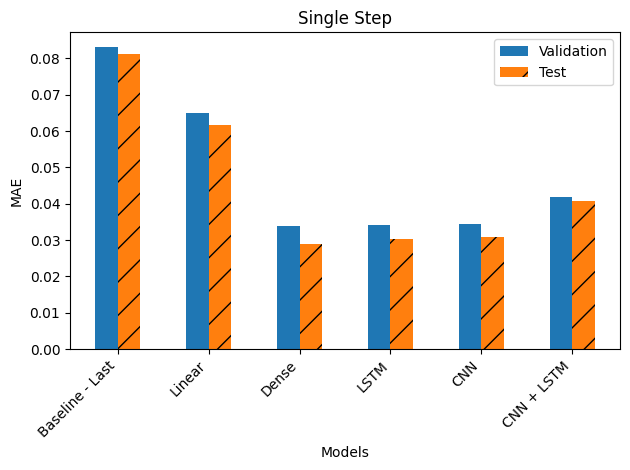

In [23]:
# single stepの結果比較
plt.title('Single Step')
plt.xlabel('Models')
plt.ylabel('MAE')
plt.bar(val_performance.keys(), [v[1] for v in val_performance.values()], width=-0.25, align='edge', label='Validation')
plt.bar(test_performance.keys(), [v[1] for v in test_performance.values()], width=0.25, align='edge', label='Test', hatch='/')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()

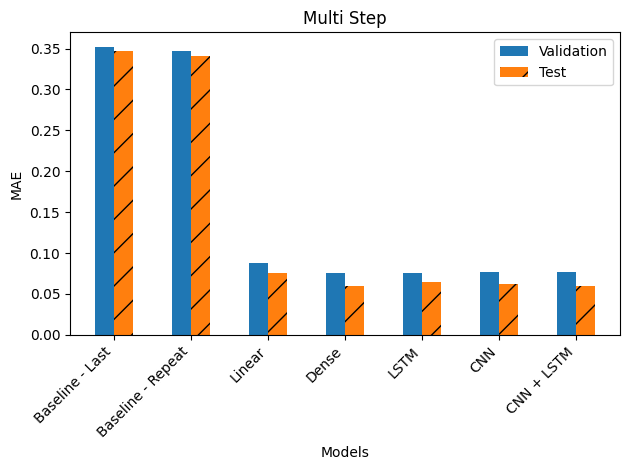

In [22]:
# multi stepの結果比較
plt.title('Multi Step')
plt.xlabel('Models')
plt.ylabel('MAE')
plt.bar(ms_val_performance.keys(), [v[1] for v in ms_val_performance.values()], width=-0.25, align='edge', label='Validation')
plt.bar(ms_test_performance.keys(), [v[1] for v in ms_test_performance.values()], width=0.25, align='edge', label='Test', hatch='/')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

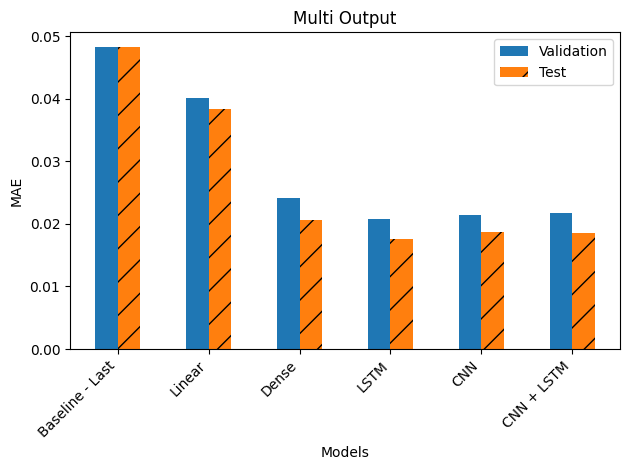

In [24]:
# multi outputの結果比較
plt.title('Multi Output')
plt.xlabel('Models')
plt.ylabel('MAE')
plt.bar(mo_val_performance.keys(), [v[1] for v in mo_val_performance.values()], width=-0.25, align='edge', label='Validation')
plt.bar(mo_test_performance.keys(), [v[1] for v in mo_test_performance.values()], width=0.25, align='edge', label='Test', hatch='/')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()